In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Risk Parity Weights:
assetA: 0.311
assetB: 0.437
assetC: 0.252

Risk Contributions (% of total risk):
assetA: 33.39%
assetB: 33.29%
assetC: 33.31%


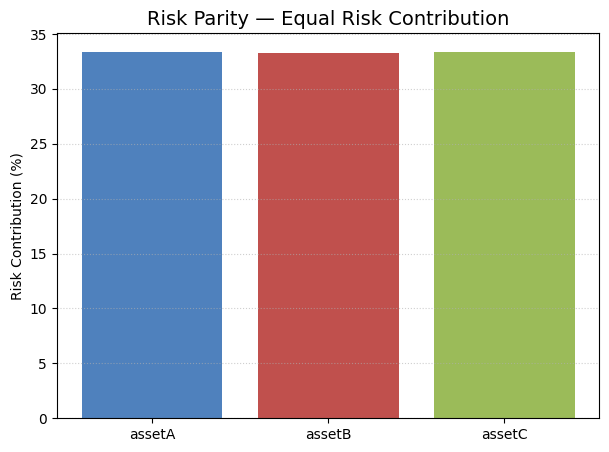

In [13]:
np.random.seed(12)

# asset = np.random.normal(mean, std, size)
asset_a = np.random.normal(0.001, 0.02, 252)
asset_b = np.random.normal(0.0008, 0.015, 252)
asset_c = np.random.normal(0.0012, 0.025, 252)

returns = pd.DataFrame({
    "assetA" : asset_a,
    "assetB" : asset_b,
    "assetC" : asset_c
})


# --- Step 1: Covariance matrix ---
cov_matrix = returns.cov()
num_assets = len(returns.columns)

# --- Step 2: Function to compute risk contributions ---
def risk_contributions(weights, cov_matrix):
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = (weights * marginal_contrib) / portfolio_vol
    risk_contrib_pct = risk_contrib / np.sum(risk_contrib)
    return risk_contrib_pct

# --- Step 3: Objective function (minimize variance of risk contributions) ---
def risk_parity_objective(weights, cov_matrix):
    rc = risk_contributions(weights, cov_matrix)
    n = len(rc)
    return np.sum((rc - 1/n)**2)

# --- Step 4: Optimization setup ---
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = np.ones(num_assets) / num_assets

opt_result = minimize(
    risk_parity_objective,
    initial_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

risk_parity_weights = opt_result.x
risk_parity_contribs = risk_contributions(risk_parity_weights, cov_matrix)

# --- Step 5: Display results ---
print("Risk Parity Weights:")
for asset, weight in zip(returns.columns, risk_parity_weights):
    print(f"{asset}: {weight:.3f}")

print("\nRisk Contributions (% of total risk):")
for asset, rc in zip(returns.columns, risk_parity_contribs):
    print(f"{asset}: {rc*100:.2f}%")

# --- Plot ---
plt.figure(figsize=(7,5))
plt.bar(returns.columns, risk_parity_contribs * 100, color=["#4F81BD","#C0504D","#9BBB59"])
plt.title("Risk Parity — Equal Risk Contribution", fontsize=14)
plt.ylabel("Risk Contribution (%)")
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.show()


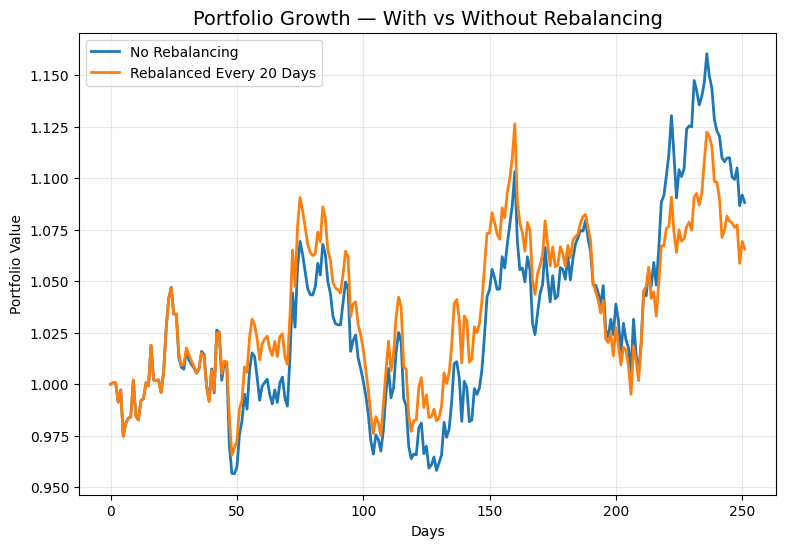

Final Value (No Rebal): 1.0882
Final Value (Rebalanced): 1.0656


In [16]:
# --- Step 2: Initial weights (use your risk parity weights) ---
risk_parity_weights = risk_parity_contribs
initial_value = 1.0  # Starting with $1

# --- Step 3: Simulate portfolio growth without rebalancing ---
values = pd.DataFrame(index=returns.index, columns=returns.columns)
values.iloc[0] = initial_value * risk_parity_weights

for t in range(1, len(returns)):
    values.iloc[t] = values.iloc[t-1] * (1 + returns.iloc[t])

# Portfolio value each day
portfolio_no_rebal = values.sum(axis=1)

# --- Step 4: Simulate with periodic rebalancing (every 20 days) ---
values_rebal = pd.DataFrame(index=returns.index, columns=returns.columns)
values_rebal.iloc[0] = initial_value * risk_parity_weights

for t in range(1, len(returns)):
    values_rebal.iloc[t] = values_rebal.iloc[t-1] * (1 + returns.iloc[t])

    # Rebalance every 20 days
    if t % 20 == 0:
        total_val = values_rebal.iloc[t].sum()
        values_rebal.iloc[t] = total_val * risk_parity_weights

portfolio_rebal = values_rebal.sum(axis=1)

# --- Step 5: Plot results ---
plt.figure(figsize=(9,6))
plt.plot(portfolio_no_rebal, label='No Rebalancing', linewidth=2)
plt.plot(portfolio_rebal, label='Rebalanced Every 20 Days', linewidth=2)
plt.title("Portfolio Growth — With vs Without Rebalancing", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Step 6: Compare final results ---
print(f"Final Value (No Rebal): {portfolio_no_rebal.iloc[-1]:.4f}")
print(f"Final Value (Rebalanced): {portfolio_rebal.iloc[-1]:.4f}")
